In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [67]:
class vertex:
    def __init__(self,x,y, name = None):
        self.x = x
        self.y = y
        self.name = name
    
    def __repr__(self):
        return f'({self.x},{self.y})'
    
    def __str__(self):
        return self.name
    
    def __eq__(self, other):
        return self.x == other.x and self.y == other.y
    
    def __lt__(self, other):
        return self.x < other.x or (self.x == other.x and self.y > other.y)
    
    def __hash__(self):
        return hash((self.x, self.y))
    
    def cross_prod(self, orig, obj):
        return (obj.x - orig.x)*(self.y-orig.y)-(obj.y-orig.y)*(self.x-orig.x)

class semi_edge:
    def __init__(self, v1 ,v2, twin = None, next_a = None, prev_a = None, inci_face = None, name = None):
        self.ini = v1
        self.fin = v2
        self.twin = twin
        self.next_a = next_a
        self.prev_a = prev_a
        self.name = name
        self.inci_face = inci_face
    
    def __repr__(self):
        return f'{self.ini} ---> {self.fin}'
                 
    def __str__(self):
        return self.name
    
    def __eq__(self, other):
        return (self.ini == other.ini) and (self.fin == other.fin)
    
    def __hash__(self):
        return hash((self.ini, self.fin))
    
class face:
    def __init__(self, name, s_e = [], v = [], side = 'Unknown'):
        self.name = name
        self.s_e = s_e
        self.v = v
        self.side = side
        
    def __repr__(self):
        return f'{self.s_e}'
    
    def __str__(self):
        return self.name
    
    def define(self):
        mn = min(self.v)
        for e in self.s_e:
            if e.ini == mn:
                nex = e.fin
            elif e.fin == mn:
                pre = e.ini
        turn = nex.cross_prod(pre, mn) # Se usa la definicion de rotacion cambiando el uso del giro
        if turn < 0:
            self.side = 'Exterior'
        elif turn >0:
            self.side = 'Interior'
        
    def plot(self):
        xcoord = [v.x for v in self.v]
        ycoord = [v.y for v in self.v]
        plt.scatter(xcoord,ycoord)
        for v in self.v:
            plt.annotate(v.name, (v.x,v.y))
        for e in self.s_e:
            plt.arrow(e.ini.x, e.ini.y, e.fin.x-e.ini.x, e.fin.y-e.ini.y, head_width=0.25)
        plt.show()
        

class dc_edge:
    def __init__(self, ps):
        self.v = [vertex(x[0], x[1]) for x in ps]
        aux = self.v.copy()
        aux.append(aux.pop(0))
        aux = [*zip(self.v, aux)]
        self.s_e = []
        for x in aux:
            self.s_e.extend([semi_edge(x[0],x[1]), semi_edge(x[1],x[0])])
            self.s_e[-2].twin = self.s_e[-1]
            self.s_e[-1].twin = self.s_e[-2]
        self.f = []
        self.name()
        self.connect()
        self.faces()
        
    def name(self):
        for i in range(len(self.v)):
            self.v[i].name = f'V{i}'
        for i in range(0, len(self.s_e), 2):
            self.s_e[i].name = f'e{i//2}0'
            self.s_e[i+1].name = f'e{i//2}1'
            
    
    def connect(self):
        for vert in self.v:
            edges = [[ind, e] for ind, e in enumerate(self.s_e) if e.ini == vert or e.fin == vert]
            ini = [d for d in edges if d[1].ini == vert]
            fin = [d for d in edges if d[1].fin == vert]

            for d in fin:
                turns = [[d[1].ini.cross_prod(vert, x[1].fin), x] for x in ini if x[1] != d[1].twin]
                if len(turns) == 0:
                    self.s_e[d[0]].next_a = self.s_e[d[0]].twin
                    self.s_e[d[0]].twin.prev_a = self.s_e[d[0]]
                else:
                    aux = min(turns, key=lambda x: x[0])
                    if aux[0] < 0:
                        aux = max(turns, key=lambda x: x[0])
                    self.s_e[d[0]].next_a = self.s_e[aux[1][0]]
                    self.s_e[aux[1][0]].prev_a = self.s_e[d[0]]
            
    def faces(self):
        count = 0;
        for i in range(len(self.s_e)):
            initial = self.s_e[i]
            if initial.inci_face is None:
                h = face(f'h{count}', s_e = [initial], v = [initial.ini, initial.fin])
                initial.inci_face = h
                self.f.append(h)
                count += 1
                current = initial.next_a
                while True:
                    current.inci_face = h
                    h.s_e.append(current)
                    h.v.append(current.fin)
                    if current.next_a == initial:
                        break
                    current = current.next_a
        for h in self.f:
            h.define()                 
            
    def reset_faces(self):
        self.f = []
        for e in self.s_e:
            e.inci_face = None
    
    def update(self, ps):
        aux = [vertex(x[0], x[1]) for x in ps]
        new = [] 
        for i in range(len(aux)):
            if aux[i] not in self.v:
                aux[i].name = f'V{int(self.v[-1].name[1:])+1}'
                self.v.append(aux[i])
                new.append(aux[i])
            else:
                aux[i] = self.v[self.v.index(aux[i])]
        aux2 = [semi_edge(aux[0],aux[1]), semi_edge(aux[1],aux[0])]
        aux2[0].twin = aux2[1]
        aux2[1].twin = aux2[0]
        aux2[0].name = f'e{int(self.s_e[-1].name[1:-1])+1}0'
        aux2[1].name = f'e{int(self.s_e[-1].name[1:-1])+1}1'
        self.s_e.extend(aux2)
        self.connect()
        self.reset_faces()
        self.faces()

    def lista(self):
        semi_edges = []
        origin = []
        twin = []
        inci_face = []
        next_e = []
        prev_e = []
        
        for i in range(len(self.s_e)):
            semi_edges.append(self.s_e[i].name)
            origin.append(self.s_e[i].ini)
            twin.append(self.s_e[i].twin)
            inci_face.append(self.s_e[i].inci_face)
            next_e.append(self.s_e[i].next_a)
            prev_e.append(self.s_e[i].prev_a)
        return pd.DataFrame.from_dict({'Semi Aristas': semi_edges, 'Origen': origin, 'Twin': twin, 'Cara incidente': inci_face, 'Next': next_e, 'Prev': prev_e})
         
    
    def plot(self):
        xcoord = [v.x for v in self.v]
        ycoord = [v.y for v in self.v]
        plt.scatter(xcoord,ycoord)
        for v in self.v:
            plt.annotate(v.name, (v.x,v.y))
        for e in self.s_e:
            plt.plot([e.ini.x, e.fin.x], [e.ini.y, e.fin.y])
        plt.show()
            


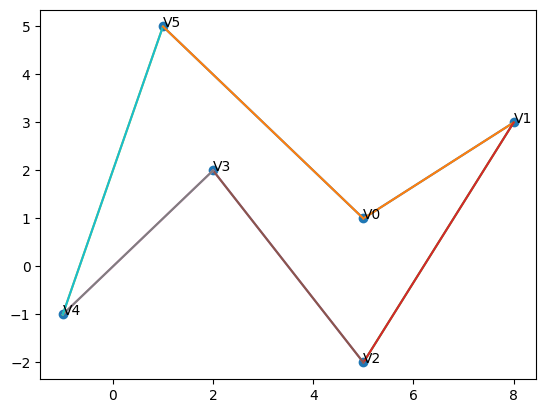

h0
[V0 ---> V1, V1 ---> V2, V2 ---> V3, V3 ---> V4, V4 ---> V5, V5 ---> V0]
Exterior


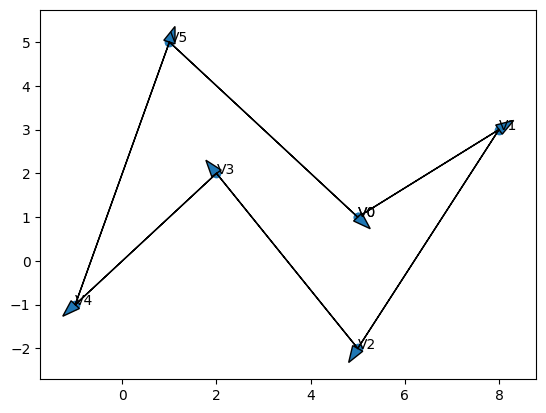

h1
[V1 ---> V0, V0 ---> V5, V5 ---> V4, V4 ---> V3, V3 ---> V2, V2 ---> V1]
Interior


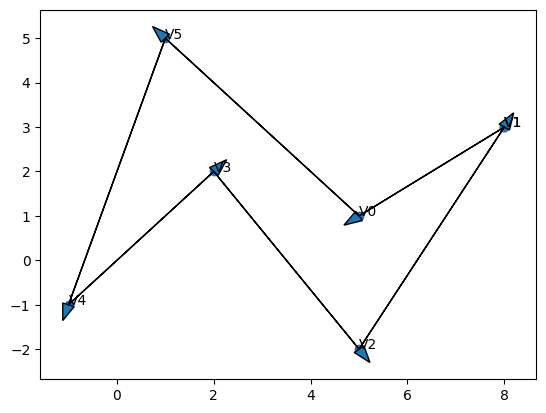

,Semi Aristas,Origen,Twin,Cara incidente,Next,Prev
0,e00,V0,e01,h0,e10,e50
1,e01,V1,e00,h1,e51,e11
2,e10,V1,e11,h0,e20,e00
3,e11,V2,e10,h1,e01,e21
4,e20,V2,e21,h0,e30,e10
5,e21,V3,e20,h1,e11,e31
6,e30,V3,e31,h0,e40,e20
7,e31,V4,e30,h1,e21,e41
8,e40,V4,e41,h0,e50,e30
9,e41,V5,e40,h1,e31,e51


In [68]:
P = [(5,1), (8,3), (5,-2), (2,2), (-1,-1), (1,5)]
AP = dc_edge(P)
AP.plot()
#for e in AP.s_e:
#    print(e)
for h in AP.f:
    print(h)
    print(h.s_e)
    print(h.side)
    h.plot()
df = AP.lista()
df

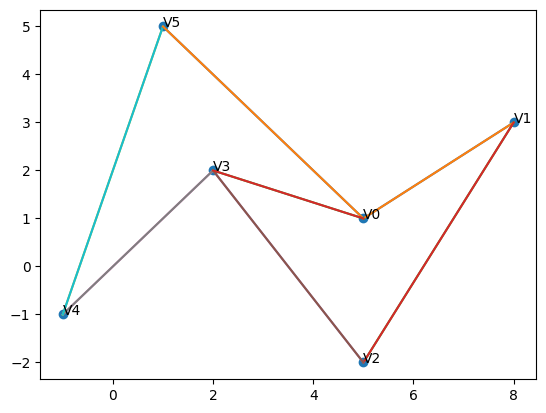

,Semi Aristas,Origen,Twin,Cara incidente,Next,Prev
0,e00,V0,e01,h0,e10,e50
1,e01,V1,e00,h1,e60,e11
2,e10,V1,e11,h0,e20,e00
3,e11,V2,e10,h1,e01,e21
4,e20,V2,e21,h0,e30,e10
5,e21,V3,e20,h1,e11,e60
6,e30,V3,e31,h0,e40,e20
7,e31,V4,e30,h2,e61,e41
8,e40,V4,e41,h0,e50,e30
9,e41,V5,e40,h2,e31,e51


In [69]:
AP.update([(5,1),(2,2)])
AP.plot()
df = AP.lista()
df

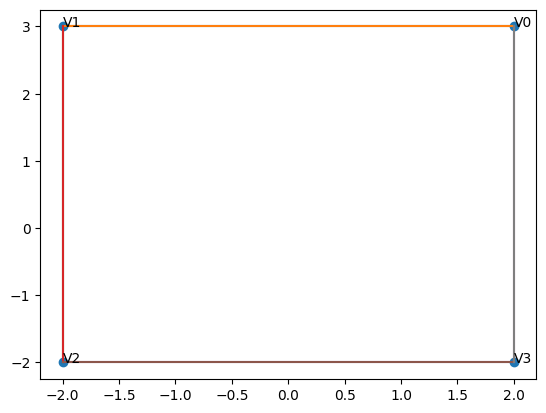

,Semi Aristas,Origen,Twin,Cara incidente,Next,Prev
0,e00,V0,e01,h0,e10,e30
1,e01,V1,e00,h1,e31,e11
2,e10,V1,e11,h0,e20,e00
3,e11,V2,e10,h1,e01,e21
4,e20,V2,e21,h0,e30,e10
5,e21,V3,e20,h1,e11,e31
6,e30,V3,e31,h0,e00,e20
7,e31,V0,e30,h1,e21,e01


In [70]:
P2 = [(2,3), (-2,3), (-2,-2), (2,-2)]
AP2 = dc_edge(P2)
AP2.plot()
df2 = AP2.lista()
df2

In [71]:
def superpos(s1,s2):
    new_se = s1.s_e
    new_se.extend(s2.s_e)
    new_se = list(set(new_se))
    print(new_se)
    
    new_v = s1.v
    new_v.extend(s2.v)
    new_v = list(set(new_v))
    print(new_v)
    
    

In [72]:
superpos(AP, AP2)

[V0 ---> V5, V2 ---> V1, V0 ---> V3, V3 ---> V2, V1 ---> V2, V1 ---> V2, V3 ---> V0, V3 ---> V4, V5 ---> V4, V0 ---> V3, V0 ---> V1, V0 ---> V1, V4 ---> V5, V3 ---> V0, V5 ---> V0, V1 ---> V0, V3 ---> V2, V2 ---> V3, V2 ---> V1, V4 ---> V3, V1 ---> V0, V2 ---> V3]
[(2,-2), (-1,-1), (-2,-2), (1,5), (5,-2), (5,1), (2,3), (8,3), (-2,3), (2,2)]


In [38]:
set([(1,2), (1,2)])

{(1, 2)}